# Example N-body simulation of a disrupting GC stream 

This notebook illustrates an example on how to use various tools to simulate stellar streams and derive properties such as mass-loss rates and stripping times, albiet working in the the approximation of a time-evolving potential. 

We will run a full N-body simulation of a disrupting globular cluster stream in a rigid body MW+LMC potential, using the GPU-accelerated N-body code in nbody_streams. We will use the AAU stream as an example, but the same procedure can be applied to any stream progenitor / ICs. 

Properties to derive from the N-body simulation include:

- mass-loss rates
- stripping times
- morphological structure along the stream track

In [1]:
import sys, os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm

import agama 
agama.setUnits(mass=1, length=1, velocity=1) #Msol, kpc, km/s. Time is in kpc/(kms/s)

import nbody_streams as nbody
G_DEFAULT = nbody.G_DEFAULT 
%matplotlib inline

In [2]:
try:
    from importlib import resources
except ImportError:
    import importlib_resources as resources

timeUnitGyr = agama.getUnits()['time'] / 1e3  # time unit is 1 kpc / (1 km/s)
print('time unit: %.3f Gyr' % timeUnitGyr) # Agama works in length/velocity

# base data directory inside package
data_dir = resources.files("nbody_streams").joinpath("data")
BASE_POT_PATH = 'potentials/MW_LMC_evolv'

# # Load the host potential
# Define file paths
potMW_path = os.path.join(data_dir, BASE_POT_PATH, 'McMillan17_streams.ini')
potLMC_path = os.path.join(data_dir, BASE_POT_PATH, 'LMC_vasiliev21.ini')
accMW_path = os.path.join(data_dir, BASE_POT_PATH, 'accMW_McM17streams')
trajLMC_path = os.path.join(data_dir, BASE_POT_PATH, 'trajLMC_McM17streams')

# # load in the MW potenital from Shipp+2021, along with reflex of the MW due to the LMC
potMW = agama.Potential(file=potMW_path)
accMW = np.loadtxt(accMW_path)
potacc  = agama.Potential(type='UniformAcceleration', file=accMW)

# # load in the LMC potential from Vasiliev+2021, along with the LMC trajectory
trajLMC = np.loadtxt(trajLMC_path)
potLMC  = agama.Potential(file=potLMC_path)
potLMCm = agama.Potential(potential=potLMC, center=trajLMC)

# # combine to make a combined total potential in MW-centric non-inertial frame.
# # The LMC moves on an orbit, the MW responds to it.
potTotal= agama.Potential(potMW, potLMCm, potacc)
print('Successfully loaded MW-LMC potential.')

time unit: 0.978 Gyr
Successfully loaded MW-LMC potential.


# Create ICs: In this case, let's use the AAU stream progenitor

In [2]:
# # Generate satellite ic's
prog_mass = 20_000 # Msun
prog_scaleradius = 0.01 # kpc
num_particles = 10_240 # multiple of 256 for optimal tiling on a GPU

pot_sat = agama.Potential(
    type='plummer', mass=prog_mass, 
    scaleRadius=prog_scaleradius
) # fixed values again

df_sat = agama.DistributionFunction(type='QuasiSpherical', potential=pot_sat)

# # generate satellite particles:
xv, masses = agama.GalaxyModel(pot_sat, df_sat).sample(num_particles) # phase-space samples of the distribution func.

# Let's run a Nbody in isolation with acceptable parameters.

In [3]:
# --- Diagnostics & Parameter Choices (Plummer Optimized) ---
# Units: kpc, Msun, Gyr.
# Equations used:
# 1. Softening (Dehnen 2001): eps = 4 * r_s / sqrt(N)
# 2. Velocity Dispersion: sigma ~ sqrt(G * M / (6 * r_s))
# 3. Time-step: dt = eta * (eps / sigma)
N = xv.shape[0]
r_s = max(1e-6, prog_scaleradius)  # Plummer scale radius (kpc)
M_tot = pot_sat.enclosedMass(10.0) # Total mass of the satellite

# 1. Calculate characteristic velocity dispersion (sigma) for a Plummer sphere
# The 1D velocity dispersion at the center is sigma^2 = G * M / (6 * r_s)
sigma_center = np.sqrt((G_DEFAULT * M_tot) / (6.0 * r_s))

# 2. Characteristic crossing time (t_cross = r_s / sigma)
t_cross = r_s / sigma_center
t_end = 20.0 * t_cross  # Integrate for 20 dynamical times
t_start = 0.0

# 3. Dehnen's optimal softening for Plummer spheres
# This balances force bias against discreteness noise
eps_softening = (4.0 * r_s) / np.sqrt(N)

# 4. Refined Time-step
# We must resolve the softening length. A particle shouldn't travel 
# more than ~10% of eps in a single step.
eta = 0.1 
dt_ideal = eta * (eps_softening / sigma_center)

# Clamp dt for safety, but prioritize the dynamical calculation
dt = float(min(dt_ideal, 2e-5)) # 2e-5 Gyr is a reasonable minimum dt for longterm stability.
print(f"--- Plummer N-Body Setup ---")
print(f"N={N}, r_s={r_s:.3e} kpc, M_tot={M_tot:.3e} Msun")
print(f"t_cross={t_cross:.3e} Gyr, t_end={t_end:.3e} Gyr")
print(f"Suggested eps={eps_softening:.3e} kpc")
print(f"Suggested dt ={dt:.3e} Gyr (eta={eta})")

# check number of particles within a softening length
print(f'No. of particles within eps pc:',(np.linalg.norm(xv[:, :3], axis=1) < eps_softening).sum())

# Check if dt is too large for the softening
steps_per_eps = eps_softening / (sigma_center * dt)
print(f"Resolution: ~{steps_per_eps:.1f} steps per softening length crossing")

--- Plummer N-Body Setup ---
N=10240, r_s=1.000e-02 kpc, M_tot=2.000e+04 Msun
t_cross=8.352e-03 Gyr, t_end=1.670e-01 Gyr
Suggested eps=3.953e-04 kpc
Suggested dt =2.000e-05 Gyr (eta=0.1)
No. of particles within eps pc: 2
Resolution: ~16.5 steps per softening length crossing


In [4]:
eps_softening = 0.0004 # in kpc, seems like a reasonable choice from above. 
dt = 2e-5 # in time Units, seems like a reasonable choice from above. 

In [5]:
def get_drift_corrected_Energy(pos, vel, m, softening, G=G_DEFAULT):
    """Compute drift corrected Total Energy of the system."""
    # 1. Calculate Center of Mass Velocity
    # v_com = sum(m_i * v_i) / sum(m_i)
    v_com = np.sum(m[:, np.newaxis] * vel, axis=0) / np.sum(m)
    
    # 2. Subtract v_com to get internal velocities
    v_internal = vel - v_com
    
    # 3. Calculate Kinetic Energy
    ke = 0.5 * np.sum(m * np.sum(v_internal**2, axis=1))
    
    # 4. Potential Energy
    phi = nbody.compute_nbody_potential_gpu(pos, m, softening=softening, G=G_DEFAULT)
    pe = 0.5 * np.sum(m * phi) # 0.5 to avoid double counting
    
    return ke + pe

# compute initial energies
pos0 = xv[:, :3].astype(float)
vel0 = xv[:, 3:].astype(float)
E0 = get_drift_corrected_Energy(pos0, vel0, masses, eps_softening, G=G_DEFAULT)

print("Initial energies:")
print(f"  E0 = {E0:.6e}  (Msun * (kpc/Gyr)^2)")

Initial energies:
  E0 = -2.549480e+04  (Msun * (kpc/Gyr)^2)


In [6]:
# # --- run the Nbody --- 
isolated = nbody.run_nbody_gpu(   # CPU uses the same APi, with addiotnal tree method. GPUs will soon have a tree code too!
    phase_space=xv.copy(),        # pass a copy to avoid accidental mutation of original samples
    masses=masses.copy(), # pass a copy to avoid accidental mutation of original masses
    time_start=t_start, # start at t=0, we will integrate forward in time.
    time_end=t_end, # we are integarting for roughly 20 crossing times. 
    dt=dt, # double the dt to speed up the run, since we are not interested in the details of the evolution
    softening=eps_softening,
    G=G_DEFAULT,
    kernel='spline',
    external_potential=None,
    output_dir="output/isolated/",
    snapshots=10, # this is good enough for testing energy conservation in isolation.
    num_files_to_write=1, # number of hdf5 files to write, written evenly in time. 
    restart_interval=1000, # this is how frequently to dump restart files. 
    continue_run=False,
    verbose=True
)

GPU N-body Integration
Particles: 10,240
Time: 0.000e+00 → 1.670e-01 (dt=2.000e-05)
Steps: 8,352 (8,352 remaining)
Kernel: spline, Softening: 0.0004
External potential: No
Snapshots: 10 (every ~835 steps)
Restart files: every 1000 steps

Transferring data to GPU...
Computing initial forces (compiling CUDA kernel)...

Starting integration...
Saved snapshot snap: 000 at step 0, time 0.000000e+00...
  Step    417/8352 | t=8.3400e-03 | Snapshots: 1/10 | 747.0 steps/s | avg 1.3ms/step | ETA 11s
  Step    834/8352 | t=1.6680e-02 | Snapshots: 1/10 | 715.6 steps/s | avg 1.4ms/step | ETA 11s
Saved snapshot id=001 at step 928, time 1.856000e-02...
  Step   1251/8352 | t=2.5020e-02 | Snapshots: 2/10 | 668.2 steps/s | avg 1.5ms/step | ETA 11s
  Step   1668/8352 | t=3.3360e-02 | Snapshots: 2/10 | 674.0 steps/s | avg 1.5ms/step | ETA 10s
Saved snapshot id=002 at step 1856, time 3.712000e-02...
  Step   2085/8352 | t=4.1700e-02 | Snapshots: 3/10 | 652.3 steps/s | avg 1.5ms/step | ETA 10s
  Step   250

(-0.2, 0.2)

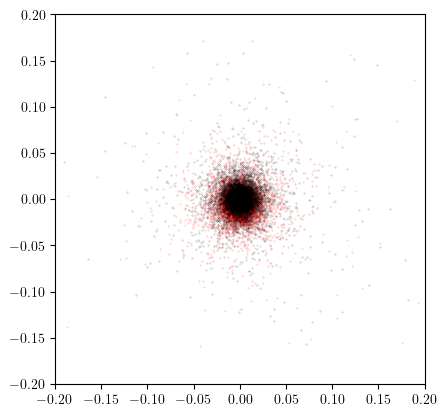

In [7]:
plt.scatter(isolated[:, 0], isolated[:, 1], c='r', s=0.1, alpha=0.3)
plt.scatter(xv[:, 0], xv[:, 1], c='k', s=0.1, alpha=0.3)
plt.gca().set_aspect('equal')
plt.xlim(-0.2, 0.2); plt.ylim(-0.2, 0.2)

In [8]:
def get_drift_corrected_Energy(pos, vel, m, softening, G=G_DEFAULT):
    """Compute drift corrected Total Energy of the system."""
    # 1. Calculate Center of Mass Velocity
    # v_com = sum(m_i * v_i) / sum(m_i)
    v_com = np.sum(m[:, np.newaxis] * vel, axis=0) / np.sum(m)
    
    # 2. Subtract v_com to get internal velocities
    v_internal = vel - v_com
    
    # 3. Calculate Kinetic Energy
    ke = 0.5 * np.sum(m * np.sum(v_internal**2, axis=1))
    
    # 4. Potential Energy
    phi = nbody.compute_nbody_potential_gpu(pos, m, softening=softening, G=G_DEFAULT, precision='float64')
    pe = 0.5 * np.sum(m * phi) # 0.5 to avoid double counting
    
    return ke + pe

def compute_tot_Energy(PartClass, nsnap):
    posvel = PartClass.read_snapshot(nsnap).dark['posvel']
    # massess = PartClass.read_snapshot(nsnap).dark['mass']
    pos0 = posvel[:, :3].astype(float)
    vel0 = posvel[:, 3:].astype(float)
    E0 = get_drift_corrected_Energy(pos0, vel0, masses, eps_softening, G=G_DEFAULT)
    return E0

isolated_gpu = nbody.ParticleReader(sim_pattern='output/isolated/snapshot.h5')
snaps, times = isolated_gpu.Times.T

# compute total energies
Etots_gpu = np.asarray([compute_tot_Energy(isolated_gpu, int(i)) for i in snaps], dtype=float)

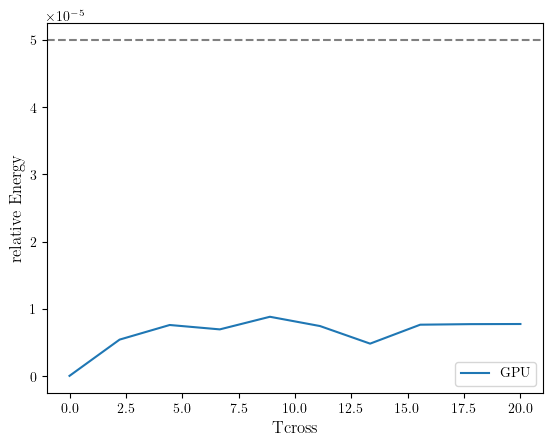

In [9]:
plt.plot(times/t_cross, np.abs(Etots_gpu/E0 -1), label='GPU')
plt.xlabel('Tcross'); plt.ylabel(r'relative Energy')
plt.axhline(0.5e-4, ls='--', c='gray')
plt.legend()

We can see that the energy is well conserved with no strict patterns appearing or monotonic behaviours appearing in the energy evolution, which is a good sign that the N-body code is working as expected in isolation. The energy conservation is at the level of ~1e-4, which is reasonable for a GPU-accelerated N-body code with float32 precision and a spline softening kernel. 

# Okay let's run a full Nbody simulation in an external host potential.

In [10]:
try:
    from importlib import resources
except ImportError:
    import importlib_resources as resources

# base data directory inside package
data_dir = resources.files("nbody_streams").joinpath("data")
BASE_POT_PATH = 'potentials/MW_LMC_evolv'

# # Load the host potential
# Define file paths
potMW_path = os.path.join(data_dir, BASE_POT_PATH, 'McMillan17_streams.ini')
potLMC_path = os.path.join(data_dir, BASE_POT_PATH, 'LMC_vasiliev21.ini')
accMW_path = os.path.join(data_dir, BASE_POT_PATH, 'accMW_McM17streams')
trajLMC_path = os.path.join(data_dir, BASE_POT_PATH, 'trajLMC_McM17streams')

# # load in the MW potenital from Shipp+2021, along with reflex of the MW due to the LMC
potMW = agama.Potential(file=potMW_path)
accMW = np.loadtxt(accMW_path)
potacc  = agama.Potential(type='UniformAcceleration', file=accMW)

# # load in the LMC potential from Vasiliev+2021, along with the LMC trajectory
trajLMC = np.loadtxt(trajLMC_path)
potLMC  = agama.Potential(file=potLMC_path)
potLMCm = agama.Potential(potential=potLMC, center=trajLMC)

# # combine to make a combined total potential in MW-centric non-inertial frame.
# # The LMC moves on an orbit, the MW responds to it.
potTotal= agama.Potential(potMW, potLMCm, potacc)
print('Successfully loaded MW-LMC potential.')

Successfully loaded MW-LMC potential.


In [11]:
timeUnitGyr = agama.getUnits()['time'] / 1e3  # time unit is 1 kpc / (1 km/s)
print('time unit: %.3f Gyr' % timeUnitGyr) # Agama works in length/velocity

time unit: 0.978 Gyr


In [12]:
# # pick some present day progenitor coordinates, we will rewind them to get the intial conditions. 
posvel_present_day = np.array([-10.93,  -3.36, -22.2,  70.4 , 188.58,  95.84]) # # AAU coords for e.g.

time_rewind = -4/timeUnitGyr # Rewind the progenitor trajectory by 4 Gyr/. Code units are L/v.

posvel_initial = agama.orbit(ic=posvel_present_day, potential=potTotal, time=time_rewind, timestart=0, trajsize=1)[1]

# # Now we have the initial conditions for the Nbody run in a host potential
xv_shifted = xv.copy() + posvel_initial # shift the satellite to the initial position

In [13]:
# # Selected as reasonable choices based on 
eps_softening=4e-04 # kpc
dt =2.000e-05 # Gyr timesteps
t_start = -4/timeUnitGyr # Gyr 
t_end = 0/timeUnitGyr # Gyr (run forward with full Nbody to present-day)

In [17]:
from datetime import timedelta

# Define constants
time_per_step = 5 / 1000  # 0.005 seconds per step -- Agama + self-gravity at F32
total_simulation_time = t_end - t_start
total_steps = total_simulation_time / dt
total_seconds = total_steps * time_per_step

# Convert to a human-readable duration
readable_time = str(timedelta(seconds=int(total_seconds)))

print(f"Total Steps to run: {int(total_steps):,}")
print(f"Estimated Wall-Clock Time: {readable_time}")

Total Steps to run: 204,542
Estimated Wall-Clock Time: 0:17:02


In [18]:
# # # --- run the Nbody ---
# final = nbody.run_nbody_gpu(
#     phase_space=xv_shifted.copy(),        # pass a copy to avoid accidental mutation of original samples
#     masses=masses.copy(),
#     time_start=t_start, # we are starting at -4 Gyr here
#     time_end=t_end, # running the simulation to present-day at 0 Gyr.
#     dt=dt,
#     softening=eps_softening,
#     G=G_DEFAULT,
#     precision='float32_kahan', # float32_kahan is recommended for GPU runs~ similar Econs as float64 but 3X faster.
#     kernel='spline',
#     external_potential=potTotal, # use the host potential. That's all one needs to do to run a full Nbody simulation in a host potential!
#     output_dir="output/host_potential/",
#     snapshots=1_000, # let's save a lot more timesteps to better resolve the stream evolution in the host potential.
#     restart_interval=1_000,
#     continue_run=False,
#     verbose=True, # turn it off if you trust the code. It's good to get the output, no matter how long. 
# )

In [29]:
# # final is (N, 6) posvel array at the final time step.
final.shape # let's plot the stream for sanity along with the progenitor location

(10240, 6)

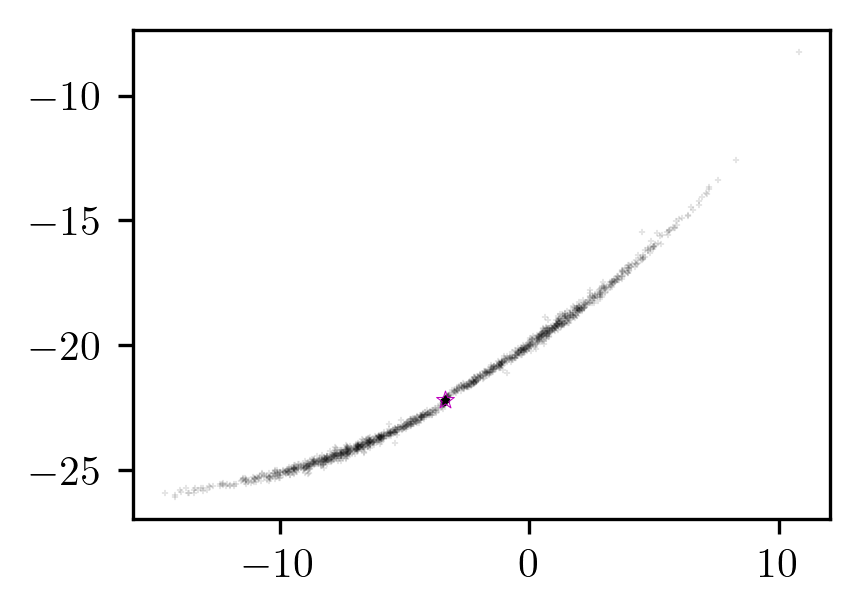

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
ax.scatter(final[:, 1], final[:, 2], c='k', s=0.1, alpha=0.1, marker='+')
ax.scatter(posvel_present_day[1], 
            posvel_present_day[2], 
            marker='*', linewidth=0.25,
            facecolor='none', edgecolor='m', s=20)
ax.set_aspect('equal')
# plt.xlim(-0.2, 0.2); plt.ylim(-0.2, 0.2)

# Simulation finished running! Let's test it out. 

In [2]:
host_snaps = nbody.ParticleReader(sim_pattern='output/host_potential/snapshot.h5', verbose=True)
snaps, times = host_snaps.Times.T

timeUnitGyr = agama.getUnits()['time'] / 1e3  # time unit is 1 kpc / (1 km/s)
# print('time unit: %.3f Gyr' % timeUnitGyr)
times_Gyr = times*timeUnitGyr  # convert to Gyr

🔍 Initializing ParticleReader for pattern: output/host_potential/snapshot.h5
   Found 1 simulation file(s).
✅   Simulation properties:
      - N_dark: 10240, N_star: 0
      - M_dark: 1.95e+00, M_star: 1.00e+00
      - time_step: 0.0
   Scanning files to map snapshot locations...
   ...found 1000 total snapshots.
✅  Loaded snapshot.times from: output/host_potential/snapshot.times


✅   Read snapshot 999 from output/host_potential/snapshot.h5 (time=-8.6601614688e-06)


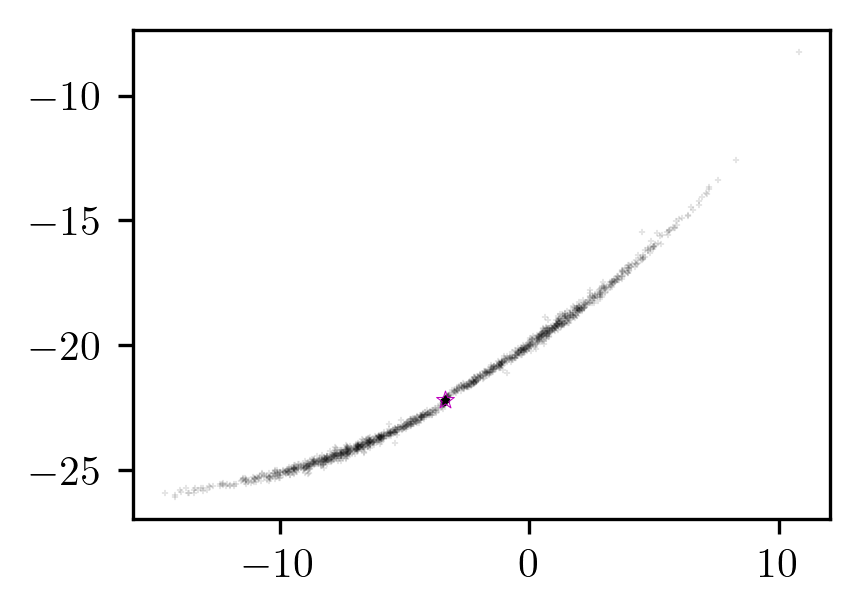

In [3]:
final = host_snaps.read_snapshot(0.0)  # read the final snapshot at time t to initialize. pass floats for time, ints for snapshot number. 
# # pick some present day progenitor coordinates, we will rewind them to get the intial conditions. 
posvel_present_day = np.array([-10.93,  -3.36, -22.2,  70.4 , 188.58,  95.84]) # # AAU coords for e.g.

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
ax.scatter(final.dark['posvel'][:, 1], final.dark['posvel'][:, 2], c='k', s=0.1, alpha=0.1, marker='+')
ax.scatter(posvel_present_day[1], 
            posvel_present_day[2], 
            marker='*', linewidth=0.25,
            facecolor='none', edgecolor='m', s=20)
ax.set_aspect('equal')

In [4]:
# let's compute what's bound and whats not. 
bound_mask, pos_cen, vel_cen = nbody.utils.iterative_unbinding(
    positions_dark=final.dark['posvel'][:, :3],
    velocity_dark=final.dark['posvel'][:, 3:],
    mass_dark=final.dark['mass'],
    center_position = [], # technically can be passed but let the code pick these.
    center_velocity = [], # technically can be passed but let the code pick these.
    potential_compute_method = 'direct_gpu', # let's use the same gravity solver.
    softening=4e-04,
)

# # let's compute the bound fraction:
print(f'Bound fraction of stars: {np.mean(bound_mask):.3f}')
# # expectedly, only about ~15% of the stars are stripped at the end of the simulation, 
# # which is reasonable for a disrupting globular cluster stream after 4 Gyr of evolution in a host potential.

[INFO] Center position (shrinking_sphere): [-10.94  -3.37 -22.21]
[INFO] Center velocity: [ 70.36 188.5   95.72]
[INFO] Iter 0: Δ bound mask = 0.13652
[INFO] Iter 1: Δ bound mask = 0.00000
[INFO] Converged after 2 iterations.


Bound fraction of stars: 0.863


# Compute stripping times from snapshot data

In [5]:
host_snaps = nbody.ParticleReader(sim_pattern='output/host_potential/snapshot.h5', verbose=False) # let's turn off logging
snaps, times = host_snaps.Times.T

timeUnitGyr = agama.getUnits()['time'] / 1e3  # time unit is 1 kpc / (1 km/s)
# print('time unit: %.3f Gyr' % timeUnitGyr)
times_Gyr = times*timeUnitGyr  # convert to Gyr

In [15]:
def track_stripping_evolution(host_snaps, softening=4e-04, verbose=False):
    # Setup Time Units
    time_unit_gyr = agama.getUnits()['time'] / 1e3
    raw_times = host_snaps.Times.T 
    
    # Sort chronologically (from -4 Gyr to 0 Gyr)
    sort_idx = np.argsort(raw_times[1]) 
    snaps_indices = raw_times[0][sort_idx]
    times_sim = raw_times[1][sort_idx]
    times_gyr = times_sim * time_unit_gyr
    
    num_particles = len(host_snaps.read_snapshot(int(snaps_indices[0])).dark['mass'])
    num_snaps = len(snaps_indices)
    
    # Storage
    stripping_info = np.full((num_particles, 3), np.nan)
    bound_fractions = np.zeros(num_snaps)

    print(f"🚀 Starting analysis for {num_snaps} snapshots...")

    for i, s_idx in enumerate(snaps_indices):
        # FIX: Force to native Python int to avoid the TypeError
        snap = host_snaps.read_snapshot(int(s_idx))
        posvel = snap.dark['posvel']
        
        # Result unpacking: ( (dark_mask, star_mask), center_pos, center_vel )
        result = nbody.utils.iterative_unbinding(
            positions_dark=posvel[:, :3],
            velocity_dark=posvel[:, 3:],
            mass_dark=snap.dark['mass'],
            potential_compute_method='direct_gpu',
            softening=softening,
            verbose=verbose 
        )
        
        # Grab the dark mask (0=unbound, 1=bound)
        current_mask = np.array(result[0][0])
        
        # A. Bound fraction
        bound_fractions[i] = np.sum(current_mask == 1) / len(current_mask)
        
        # B. Stripping logic (unbound now AND not recorded yet)
        newly_stripped = (current_mask == 0) & np.isnan(stripping_info[:, 0])
        
        stripping_info[newly_stripped, 0] = s_idx
        stripping_info[newly_stripped, 1] = times_sim[i]
        stripping_info[newly_stripped, 2] = times_gyr[i]
        
        if i % 50 == 0:
            print(f"Snap {i}/{num_snaps} | Time: {times_gyr[i]:.2f} Gyr | Bound: {bound_fractions[i]:.3f}")

    return stripping_info, bound_fractions, times_gyr
    
# --- Execution ---
stripping_data, bound_hist, t_gyr = track_stripping_evolution(host_snaps)

# Save the results
np.save('output/host_potential/stripping_info.npy', stripping_data)
np.save('output/host_potential/bound_fraction_history.npy', np.vstack([t_gyr, bound_hist]))

🚀 Starting analysis for 1000 snapshots...
Snap 0/1000 | Time: -4.00 Gyr | Bound: 1.000
Snap 50/1000 | Time: -3.80 Gyr | Bound: 0.996
Snap 100/1000 | Time: -3.60 Gyr | Bound: 0.982
Snap 150/1000 | Time: -3.40 Gyr | Bound: 0.964
Snap 200/1000 | Time: -3.20 Gyr | Bound: 0.960
Snap 250/1000 | Time: -3.00 Gyr | Bound: 0.952
Snap 300/1000 | Time: -2.80 Gyr | Bound: 0.938
Snap 350/1000 | Time: -2.60 Gyr | Bound: 0.935
Snap 400/1000 | Time: -2.40 Gyr | Bound: 0.932
Snap 450/1000 | Time: -2.20 Gyr | Bound: 0.918
Snap 500/1000 | Time: -2.00 Gyr | Bound: 0.915
Snap 550/1000 | Time: -1.80 Gyr | Bound: 0.911
Snap 600/1000 | Time: -1.60 Gyr | Bound: 0.899
Snap 650/1000 | Time: -1.40 Gyr | Bound: 0.896
Snap 700/1000 | Time: -1.20 Gyr | Bound: 0.894
Snap 750/1000 | Time: -1.00 Gyr | Bound: 0.884
Snap 800/1000 | Time: -0.80 Gyr | Bound: 0.880
Snap 850/1000 | Time: -0.60 Gyr | Bound: 0.878
Snap 900/1000 | Time: -0.40 Gyr | Bound: 0.869
Snap 950/1000 | Time: -0.20 Gyr | Bound: 0.866


As once can see from above, the stripping is fairly episodic with most of the stripping happening at pericentric passages. One might expect this but now can this stripping be modelled with simple Gaussian sampling that can be used for particle spray methods. 

# Sample stripping times for Particle Spray

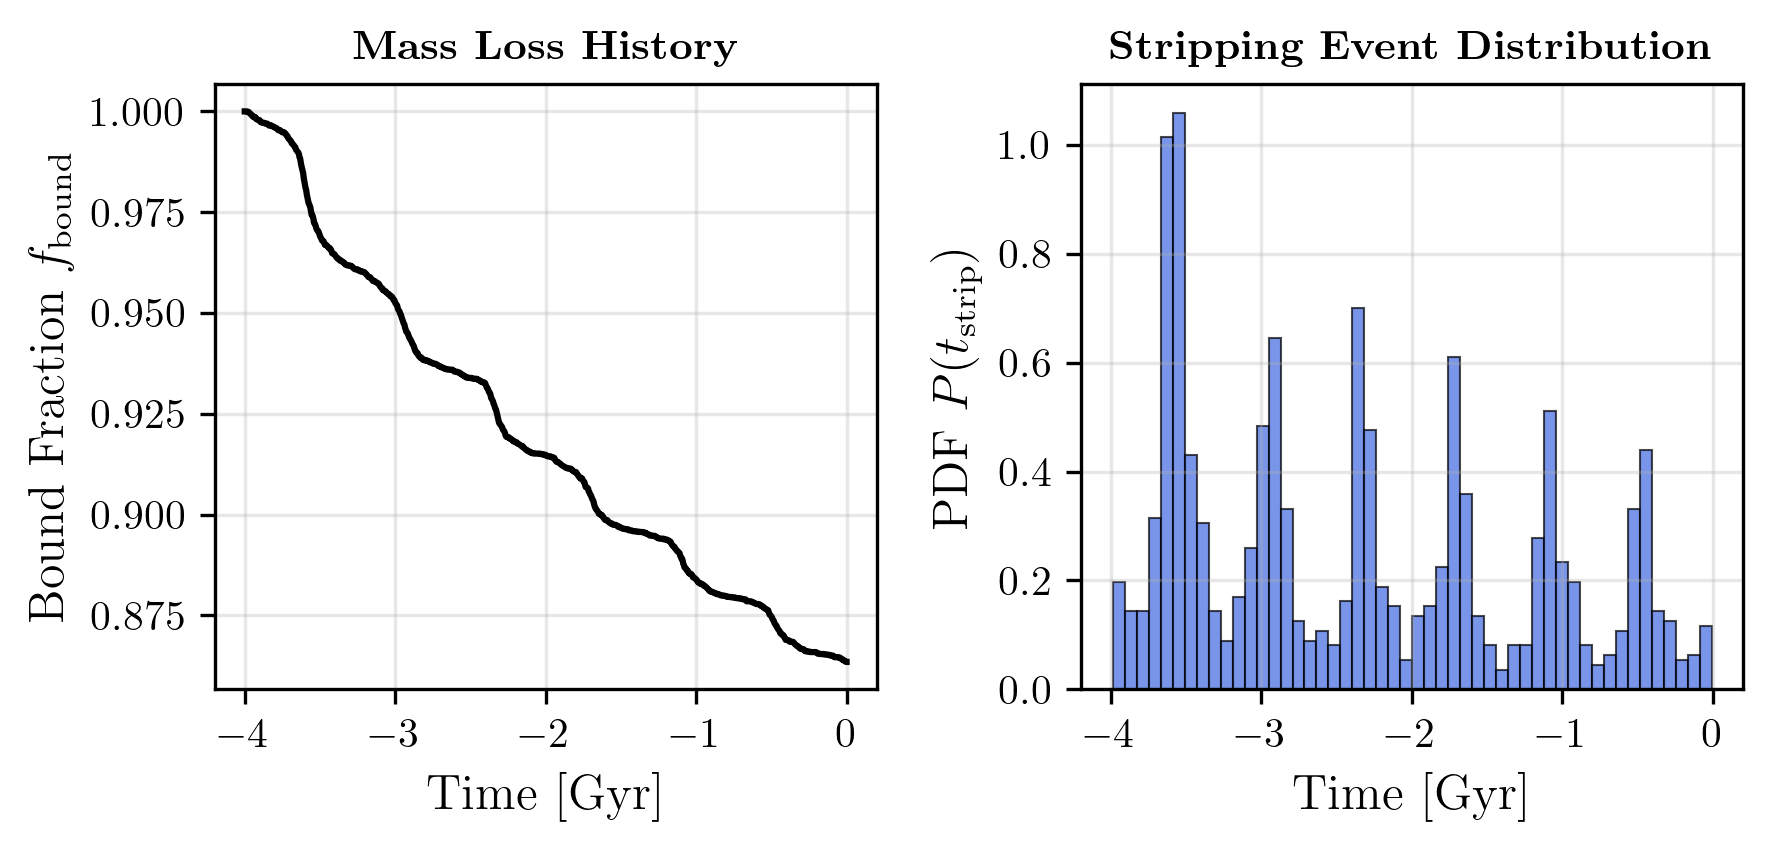

In [3]:
# --- 1. Load the data ---
# stripping_info shape: (N_particles, 3) -> [snap, t_sim, t_Gyr]
stripping_info = np.load('output/host_potential/stripping_info.npy')
# bound_hist shape: (2, N_snaps) -> [t_Gyr, fraction]
bound_hist = np.load('output/host_potential/bound_fraction_history.npy')

t_strip_all = stripping_info[:, 2]
t_strip_valid = t_strip_all[~np.isnan(t_strip_all)] # Only particles that actually stripped

# --- 2. Plotting ---
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300, sharex=True)
plt.subplots_adjust(hspace=0.3)

# Top Plot: Bound Fraction
ax[0].plot(bound_hist[0], bound_hist[1], color='black', lw=1.5)
ax[0].set_ylabel(r'Bound Fraction $f_{\text{bound}}$')
ax[0].grid(alpha=0.3)
ax[0].set_title(r'\textbf{Mass Loss History}', fontsize=10)
ax[0].set_xlabel(r'Time [Gyr]')
# Bottom Plot: Stripping Time Histogram
ax[1].hist(t_strip_valid, bins=50, density=True, color='royalblue', alpha=0.7, edgecolor='black', lw=0.5)
ax[1].set_ylabel(r'PDF $P(t_{\text{strip}})$')
ax[1].set_xlabel(r'Time [Gyr]')
ax[1].grid(alpha=0.3)
ax[1].set_title(r'\textbf{Stripping Event Distribution}', fontsize=10)

plt.tight_layout()
plt.show()

In [4]:
from scipy.interpolate import interp1d

def approx_episodic_stripping_times(
    times: np.ndarray, 
    orbit: np.ndarray, 
    num_samples: int = 5001, 
    concentration: float = 0.35,
) -> np.ndarray:
    positions = orbit[:, :3]
    
    # --- 1. Identify Pericenters ---
    distances = np.linalg.norm(positions, axis=1)
    d_dist = np.diff(distances)
    peri_mask = (d_dist[:-1] < 0) & (d_dist[1:] > 0)
    peri_indices = np.where(peri_mask)[0] + 1 
    
    # --- 2. Create Weighting (PDF) ---
    if len(peri_indices) > 1:
        sigma = np.mean(np.diff(times[peri_indices])) / 4.0
    else:
        sigma = (times[-1] - times[0]) / 8.0
    
    time_diffs = times[:, None] - times[peri_indices][None, :]
    gaussians = np.exp(-(time_diffs**2) / (2 * sigma**2))
    weights = gaussians.sum(axis=1)
    weights = weights ** concentration
    
    # Add tiny epsilon to ensure no zero-probability regions
    weights += 1e-10 
    weights /= weights.sum()
    cumulative_weights = np.cumsum(weights)
    cumulative_weights = np.insert(cumulative_weights, 0, 0.0)
    extended_times = np.insert(times, 0, times[0])

    # --- 3. BOUNDARY-SAFE CONTINUOUS SAMPLING ---
    eps = 1e-10 
    total_ramp = num_samples * eps
    
    # We shrink the available range by the total_ramp size
    t_min = times[0]
    t_max_safe = times[-1] - total_ramp
    
    # Safety check: if the simulation is shorter than the ramp (rare)
    if t_max_safe <= t_min:
        t_max_safe = times[-1]
        eps = (t_max_safe - t_min) / (num_samples * 10)

    uniform_samples = np.sort(np.random.uniform(0, 1, num_samples))
    
    # Map samples to the [t_min, t_max_safe] range
    episodic_times = np.interp(uniform_samples, cumulative_weights, extended_times)
    # Re-scale to ensure it fits within the safe window
    episodic_times = t_min + (episodic_times - t_min) * (t_max_safe - t_min) / (times[-1] - t_min)

    # --- 4. VECTORIZED UNIQUENESS GUARD ---
    # Adding the ramp now will push the last element to exactly times[-1]
    episodic_times += np.arange(num_samples) * eps
    
    return episodic_times

def target_sample_stripping_times(stripping_times, n_samples):
    """
    Samples N unique times from the empirical stripping PDF.
    Ensures times are sorted and unique for interpolation routines.
    """
    # 1. Clean data and sort
    ts = np.sort(stripping_times[~np.isnan(stripping_times)])
    
    # 2. Create an empirical CDF
    # We add a small epsilon to the probabilities to ensure uniqueness
    y = np.linspace(0, 1, len(ts))
    
    # 3. Use Inverse Transform Sampling
    # Map [0, 1] back to [t_start, t_end]
    inv_cdf = interp1d(y, ts, kind='linear', fill_value="extrapolate")
    
    # Sample linearly in probability space to get a smooth "spray"
    # or use np.random.uniform(0, 1, n_samples) if you want stochasticity
    p_samples = np.linspace(0, 1, n_samples)
    sampled_times = inv_cdf(p_samples)
    
    # 4. Ramp check & Uniqueness 
    # Add a tiny jitter (1e-8) if duplicates exist due to interpolation limits
    if len(np.unique(sampled_times)) < n_samples:
        sampled_times += np.linspace(0, 1e-8, n_samples)
        
    return np.sort(sampled_times)

## Let's run the regular Particle-spray models to start

In [5]:
# # progenitor profile + num particles
prog_mass = 20_000 # Msun
prog_scaleradius = 0.01 # kpc
num_particles = 10_240 # multiple of 256 for optimal tiling on a GPU

# # progenitor ics + Age
posvel_present_day = np.array([-10.93,  -3.36, -22.2,  70.4 , 188.58,  95.84]) # # AAU coords for e.g.
Age_of_stream = 4/timeUnitGyr # Rewind the progenitor trajectory by 4 Gyr/. Code units are L/v.

In [6]:
# # let's run a particle spray with vanilla->uniform stripping times. 
spray_uniform = nbody.fast_sims.create_particle_spray_stream(
    pot_host=potTotal, 
    initmass=prog_mass, 
    scaleradius=prog_scaleradius, 
    sat_cen_present=posvel_present_day, 
    prog_pot_kind='plummer', 
    time_total=Age_of_stream, 
    time_end=0.0,    
    num_particles=num_particles, 
)

## Let's try the sampling stripping time methods: 

In [7]:
gauss_stripping = approx_episodic_stripping_times(
    spray_uniform['times'], spray_uniform['prog_xv'], # progenitor orbit
    len(spray_uniform['times']), # num of times: nnum_particles//2 + 1
    concentration=3
)

distrib_stripping = target_sample_stripping_times(
    stripping_times=t_strip_valid, 
    n_samples=len(spray_uniform['times'])
)

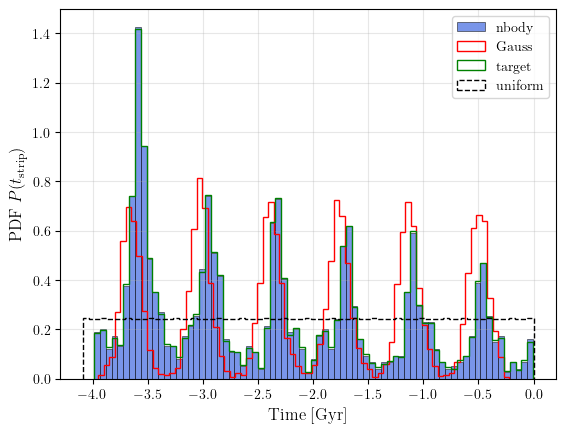

In [8]:
# Bottom Plot: Stripping Time Histogram
bins = 75
plt.hist(t_strip_valid, bins=bins, density=True, 
         color='royalblue', alpha=0.7, edgecolor='black', lw=0.5, label='nbody');

plt.hist(gauss_stripping, bins=bins, density=True, 
         histtype='step', label='Gauss', color='r');

plt.hist(distrib_stripping, bins=bins, density=True, 
         histtype='step', label='target', color='g');

plt.hist(spray_uniform['times'], bins=bins, density=True, 
         histtype='step', label='uniform', color='k', ls='--');


plt.ylabel(r'PDF $P(t_{\text{strip}})$')
plt.xlabel(r'Time [Gyr]')
plt.grid(alpha=0.3)
plt.legend()

Gaussian stripping effects can be controlled using the concentration parameter in this example. It's worth noting that target sampling the stripping times from the actual distribution derived from the N-body simulation provides a more accurate representation of the stripping history, which can be crucial for modeling the stream's morphology and kinematics.

## Particle Spray with non-uniform stripping + Restricted Nbody

In [9]:
spray_gauss_stripp = nbody.fast_sims.create_particle_spray_stream(
    pot_host=potTotal, 
    initmass=prog_mass, 
    scaleradius=prog_scaleradius, 
    sat_cen_present=posvel_present_day, 
    prog_pot_kind='plummer', 
    time_total=Age_of_stream, 
    time_end=0.0,
    time_stripping=gauss_stripping,
    num_particles=num_particles, 
)

spray_nbody_stripp = nbody.fast_sims.create_particle_spray_stream(
    pot_host=potTotal, 
    initmass=prog_mass, 
    scaleradius=prog_scaleradius, 
    sat_cen_present=posvel_present_day, 
    prog_pot_kind='plummer', 
    time_total=Age_of_stream, 
    time_end=0.0,
    time_stripping=distrib_stripping,
    num_particles=num_particles, 
)

# # let's also run a restricted Nbody which approx Nbody stimes.
restrict_nbd = nbody.fast_sims.run_restricted_nbody(
    pot_host=potTotal, 
    initmass=prog_mass, 
    scaleradius=prog_scaleradius, 
    sat_cen_present=posvel_present_day, 
    prog_pot_kind='plummer', 
    time_total=Age_of_stream, 
    time_end=0.0,
    num_particles=num_particles, 
    save_rate=300
)

Simulating Restricted N-body:   0%|          | 0/22 [00:00<?, ?it/s]

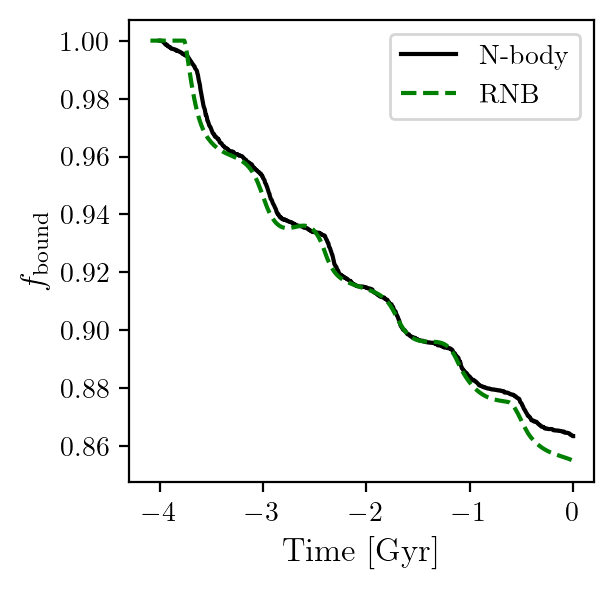

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200, sharex=True)
plt.plot(bound_hist[0], bound_hist[1], color='black', lw=1.5, label='N-body')
plt.plot(restrict_nbd['times'], restrict_nbd['bound_mass']/prog_mass, color='g', ls='--', lw=1.5, label='RNB')
plt.ylabel(r'$f_{\text{bound}}$'); plt.xlabel(r'Time [Gyr]')
plt.legend()

🔍 Initializing ParticleReader for pattern: output/host_potential/snapshot.h5
   Found 1 simulation file(s).
✅   Simulation properties:
      - N_dark: 10240, N_star: 0
      - M_dark: 1.95e+00, M_star: 1.00e+00
      - time_step: 0.0
   Scanning files to map snapshot locations...
   ...found 1000 total snapshots.
✅  Loaded snapshot.times from: output/host_potential/snapshot.times
✅   Read snapshot 999 from output/host_potential/snapshot.h5 (time=-8.6601614688e-06)


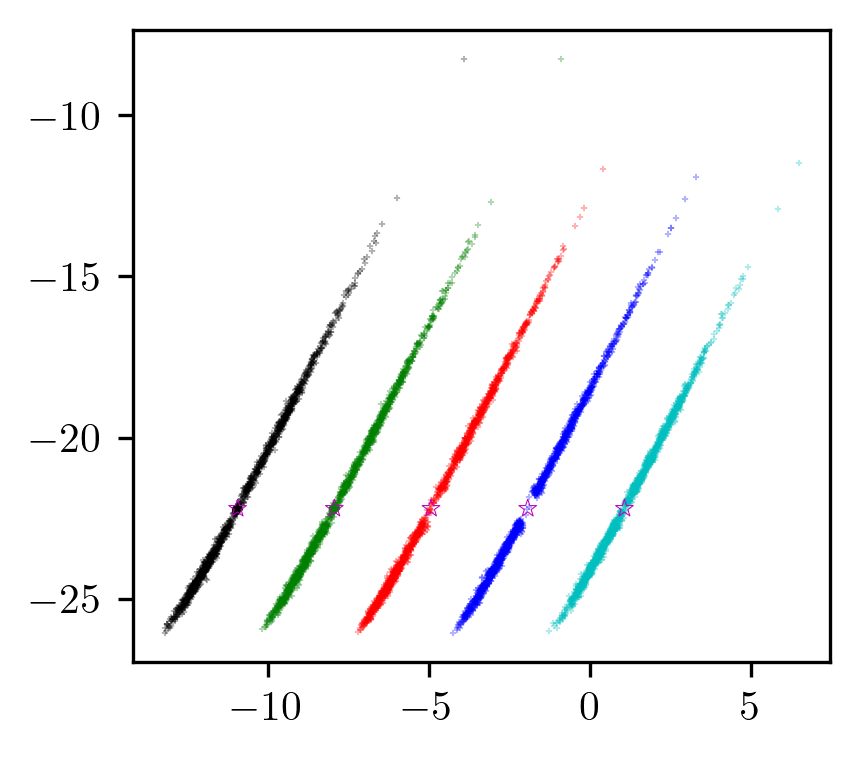

In [11]:
# # let's plot all the results and compare the structure
host_snaps = nbody.ParticleReader(sim_pattern='output/host_potential/snapshot.h5', verbose=True)

times_Gyr = host_snaps.Times[:, 1]*timeUnitGyr  # convert to Gyr
final = host_snaps.read_snapshot(0.0)  # read the final snapshot at time t to initialize. pass floats for time, ints for snapshot number. 
# # pick some present day progenitor coordinates, we will rewind them to get the intial conditions. 
posvel_present_day = np.array([-10.93,  -3.36, -22.2,  70.4 , 188.58,  95.84]) # # AAU coords for e.g.

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)

s, alpha = 0.2, 0.3
x_ax, y_ax = 0, 2


ax.scatter(final.dark['posvel'][:, x_ax], final.dark['posvel'][:, y_ax], 
           c='k', s=s, alpha=alpha, marker='+', label='N-body')

ax.scatter(restrict_nbd['part_xv'][:, -1, x_ax] + 3, restrict_nbd['part_xv'][:, -1, y_ax], 
           c='g', s=s, alpha=alpha, marker='+', label='RNB')


# down sample spray models. Decide how many particles you want to keep (e.g., 20% of the total)
# Or just pick a fixed number like 5000
total_particles = len(spray_nbody_stripp['part_xv'])
num_sample = int(total_particles * 0.15) 

# 2. Generate random unique indices
rng = np.random.default_rng()  # Modern numpy random generator
idx = rng.choice(total_particles, size=num_sample, replace=False)

# idx = range(num_particles)

ax.scatter(spray_nbody_stripp['part_xv'][idx, x_ax] + 6, spray_nbody_stripp['part_xv'][idx, y_ax], 
           c='r', s=s, alpha=alpha, marker='+', label='Spray-Nbody')
ax.scatter(spray_gauss_stripp['part_xv'][idx, x_ax] + 9, spray_gauss_stripp['part_xv'][idx, y_ax], 
           c='b', s=s, alpha=alpha, marker='+', label='Spray-Gauss')
ax.scatter(spray_uniform['part_xv'][idx, x_ax] + 12, spray_uniform['part_xv'][idx, y_ax], 
           c='c', s=s, alpha=alpha, marker='+', label='Spray-Uni')


for add in range(0, 13, 3):
    ax.scatter(posvel_present_day[x_ax]+add, 
                posvel_present_day[y_ax], 
                marker='*', linewidth=0.25,
                facecolor='none', edgecolor='m', s=20)

ax.set_aspect('equal')

In [12]:
phi1_nbody, phi2_nbody = nbody.coords.generate_stream_coords(final.dark['posvel'], posvel_present_day, optimizer_fit=True)
phi1_rnb, phi2_rnb = nbody.coords.generate_stream_coords(restrict_nbd['part_xv'][:, -1], posvel_present_day, optimizer_fit=True)
phi1_sp_nb, phi2_sp_nb = nbody.coords.generate_stream_coords(spray_nbody_stripp['part_xv'], posvel_present_day, optimizer_fit=True)
phi1_sp_gaus, phi2_sp_gaus = nbody.coords.generate_stream_coords(spray_gauss_stripp['part_xv'], posvel_present_day, optimizer_fit=True)
phi1_sp_uni, phi2_sp_uni = nbody.coords.generate_stream_coords(spray_uniform['part_xv'], posvel_present_day, optimizer_fit=True)

(-22.0, 30.0)

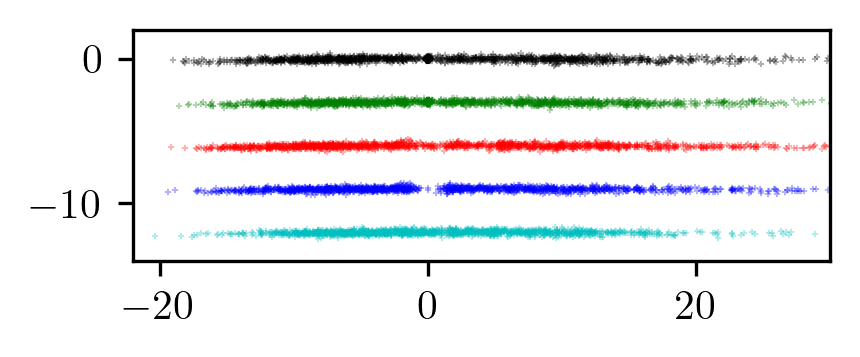

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1), dpi=300)

s, alpha = 0.2, 0.3

ax.scatter(phi1_nbody, phi2_nbody, 
           c='k', s=s, alpha=alpha, marker='+', label='N-body')

ax.scatter(phi1_rnb, phi2_rnb-3, 
           c='g', s=s, alpha=alpha, marker='+', label='RNB')

ax.scatter(phi1_sp_nb[idx], phi2_sp_nb[idx]-6, 
           c='r', s=s, alpha=alpha, marker='+', label='Spray-Nbody')
ax.scatter(phi1_sp_gaus[idx], phi2_sp_gaus[idx]-9, 
           c='b', s=s, alpha=alpha, marker='+', label='Spray-Gauss')
ax.scatter(phi1_sp_uni[idx], phi2_sp_uni[idx]-12, 
           c='c', s=s, alpha=alpha, marker='+', label='Spray-Uni')

# ax.set_aspect('equal')

ax.set_ylim(-14, 2); ax.set_xlim(-22, 30) 